## Student #1 ID:

## Student #2 ID:

# Exercise 3: Clustering

In this assignment you will implement clustering algorithms as learned in class.

## Read the following instructions carefully:

1. You are responsible for the correctness of your code and should add as many tests as you see fit. Those tests will not be graded nor checked.
1. You are free to add code and markdown cells as you see fit.
1. Write your functions in this jupyter notebook only. Do not create external python modules and import from them.
1. You are allowed to use functions and methods from the [Python Standard Library](https://docs.python.org/3/library/) and [numpy](https://www.numpy.org/devdocs/reference/) only, unless otherwise mentioned.
1. Your code must run without errors
1. Write your own code. Cheating will not be tolerated. 
1. Answers to qualitative questions should be written in **markdown cells (with $\LaTeX$ support)**.
1. Submit this jupyter notebook only using your ID as a filename. No not use ZIP or RAR. For example, your submission should look like this: `123456789.ipynb` if you worked by yourself or `123456789_987654321.ipynb` if you worked in pairs.

## PART 1: color image quantization

Color image quantization is the process of transforming an image so that it can be represented with a small subset of colors; a subset smaller than the image's original palette size. Image quantization is a form of lossy data compression since the number of bits used for the palette is reduced. During this compression some data is lost and therefore we must use a careful algorithm that will minimize the perceived difference between the original image and its quantized counterpart. Other than compression, image quantization plays an important role in image recognition algorithms.

When representing images in true color, each pixel is represented by 3 RGB components and each one of the 3 RGB components is represented by 8 bits and can take a value from 0 to 255. This means that in true color representation one can use 2^24≈16 Million different colors. In this exercise we will perform image quantization from images given in true color into 256, 16 or even less colors.

There are many algorithms for quantization. In this exercise, you are going to use K-means in color space to achieve quantization. The color (a point in RGB space) assigned to each pixel is the color of the centroid of the cluster. 

To summarize, every pixel in the image is a point in the three dimensional RGB space. We want to cluster these points into k clusters and then replace each pixel by the centroid of the cluster to which it was assigned to obtain the compressed image.

You might need to install skimage using `conda install -c conda-forge scikit-image`.

In [17]:
from skimage import io
from tqdm import trange
import numpy as np 
import matplotlib.pyplot as plt
# make matplotlib figures appear inline in the notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (14.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
import warnings
warnings.simplefilter('ignore')
# make the notebook automatically reload external python modules
%load_ext autoreload
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


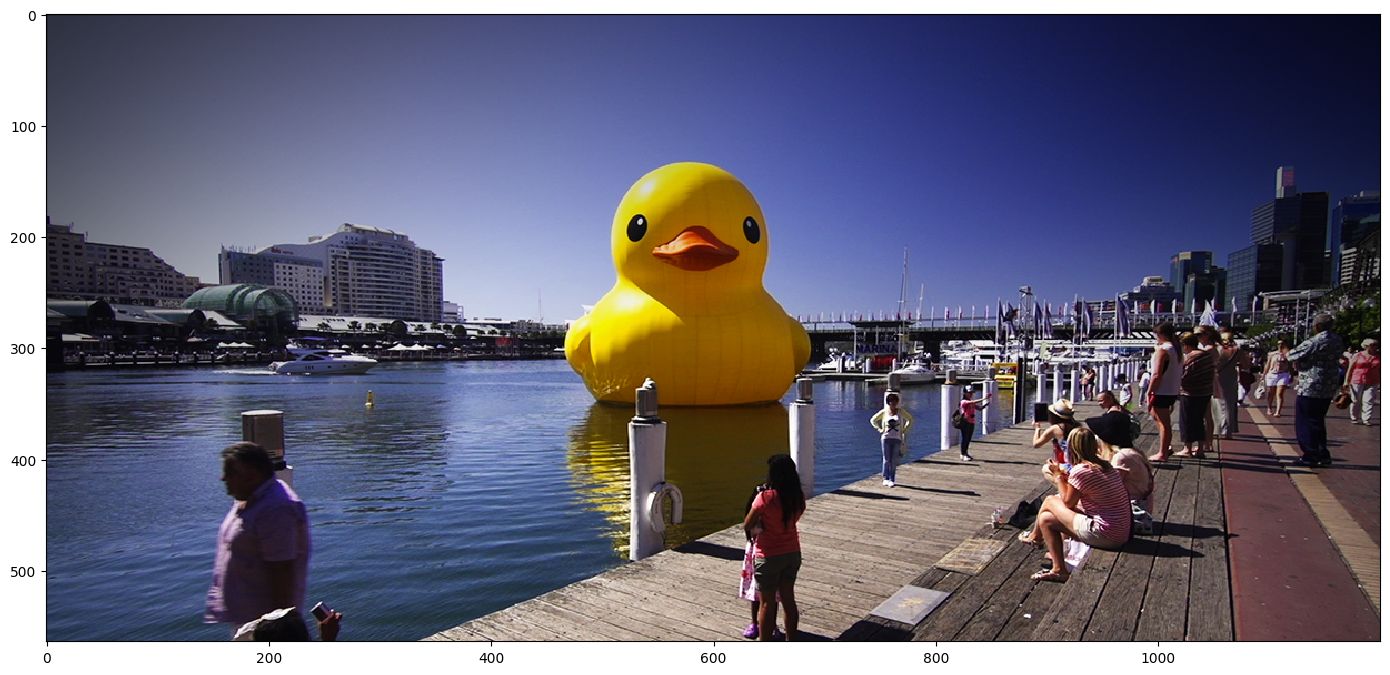

(564, 1200, 3)


In [18]:
# load the image and confirm skimage is imported properly.
image = io.imread('small_duck.jpg')
io.imshow(image)
io.show()
print(image.shape)

This single image has over 2 million values. Make sure your code is vectorized and efficient!

In [19]:
# save the dimensions of the image and reshape it for easier manipulation
rows = image.shape[0]
cols = image.shape[1]
image = image.reshape(image.shape[0]*image.shape[1],3)
print(image.shape)
print(image[:5])

(676800, 3)
[[62 64 85]
 [46 49 64]
 [53 56 73]
 [51 57 73]
 [52 58 74]]


## Random centroids (15 points)

Each centroid is a point in RGB space (color) in the image. This function should uniformly pick `k` centroids from the dataset.

Input: a single image of shape `(num_instances, 3)` and `k`, the number of centroids. Notice we are flattening the image to a two dimentional array.
Output: Randomly chosen centroids of shape `(k,3)`.

In [21]:
def get_random_centroids(X, k):
    centroids = []
    ###########################################################################
    # TODO: Implement the function.                                           #
    ###########################################################################
    indices = np.random.choice(X.shape[0], k, replace=False)
    centroids = X[indices]
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    return centroids

In [30]:
get_random_centroids(image, 5)

array([[106,  87,  83],
       [ 92, 100, 149],
       [111, 126, 185],
       [  9,  10,  15],
       [118, 123, 142]], dtype=uint8)

## Distance function (25 points)

The Minkowski distance is a metric which can be considered as a generalization of the Euclidean and Manhattan distances. 

The Minkoski distance of order $p$ between two points: $\vec{x}=(x_1, ..., x_n)$ and $\vec{y}=(y_1, ..., y_n)$ is:
$$D(\vec{x},\vec{y}) = (\sum_{i=1}^n \mid x_i - y_i \mid ^p)^{\frac{1}{p}}$$

Implement the function `lp_distance` (=Minkoski distance).

Inputs: 
* a single image of shape `(num_instances, 3)` 
* the centroids `(k, 3)`
* the distance parameter p

output: array of shape `(k, num_instances)` thats holds the distances of all points in RGB space from all centroids

In [31]:
def lp_distance(X, centroids, p=2):
    distances = []
    ###########################################################################
    # TODO: Implement the function.                                           #
    ###########################################################################
    # X shape: (num_instances, 3)
    # centroids shape: (k, 3)
    # Compute differences using broadcasting
    diff = centroids[:, np.newaxis, :] - X[np.newaxis, :, :]
    # Compute Minkowski distance: sum(|x_i - y_i|^p)^(1/p)
    distances = np.sum(np.abs(diff) ** p, axis=2) ** (1/p)
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    return distances

## Kmeans algorithm (40 points)

Calculate the locally optimal centroids as learned in class. At each iteration, assign every RGB point to the closest centroids and calculate new centroids by averaging the points that were assigned to every centroid. This function stops 
when no improvement was made or once max_iter iterations passed.

A reasonable implementation runs on a Core i7 CPU in less than 2 minutes with `k=16`.

In [ ]:
def kmeans(X, k, p ,max_iter=100):
    """
    Inputs:
    - X: a single image of shape (num_features, 3).
    - k: number of centroids.
    - p: the parameter governing the distance measure.
    - max_iter: the maximum number of iterations to perform.
    Outpust:
    - The calculated centroids
    - The final assignment of all RGB points to the closest centroids
    """
    centroids = get_random_centroids(X, k)
    classes = np.zeros(X.shape[0], dtype=int)
    ###########################################################################
    # TODO: Implement the function.                                           #
    ###########################################################################
    for iteration in range(max_iter):
        # Store old centroids to check for convergence
        old_centroids = centroids.copy()
        
        # Assign each point to the closest centroid
        distances = lp_distance(X, centroids, p)  # shape: (k, num_instances)
        classes = np.argmin(distances, axis=0)  # Find closest centroid for each point
        
        # Update centroids by computing mean of assigned points
        for i in range(k):
            points_in_cluster = X[classes == i]
            if len(points_in_cluster) > 0:
                centroids[i] = points_in_cluster.mean(axis=0)
        
        # Check for convergence
        if np.allclose(old_centroids, centroids):
            break
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
    return centroids, classes

In [ ]:
centroids, classes = kmeans(image, 16, p=1, max_iter=100)

We obtained the locally optimal centroids (colors) from our image. To reconstruct the compressed image, we need to specify the color for each pixel that our algorithm associated with some centroid. The following cell does that for you.

In [ ]:
classes = classes.reshape(rows,cols) 
compressed_image = np.zeros((classes.shape[0], classes.shape[1], 3), dtype=np.uint8)
for i in range(classes.shape[0]):
    for j in range(classes.shape[1]):
            compressed_image[i,j,:] = centroids[classes[i,j],:]
io.imshow(compressed_image)
io.show()

## PART 2:  High dimensional data (20 points)

In [ ]:
from sklearn.cluster import KMeans

The file 'data.csv' contains read counts from a scRNA-Seq experiment. The dataset contains 1513 samples with expression data for 31089 genes. We will load the data and experiment with dimensionality reduction using k-means clustering.

In [ ]:
# Load data
X = np.loadtxt('data.csv',delimiter=',',dtype='int')
X.shape

Perform k-means clustering on the cells in the data using sklearn KMeans and report your results.
In your analysis consider filtering and normalization of the data and the number of clusters. Make sure to explain your decisions and support them with relevant analyses and plots.

In [ ]:
###########################################################################
# TODO: START OF YOUR CODE                                                #
###########################################################################
pass    
###########################################################################
#                             END OF YOUR CODE                            #
###########################################################################